# Sentiment Analysis

Here we demonstrate sentiment analysis on a group of student feedback comments. This involves classifying the comments as 'positive', 'negative', or 'neutral'. 

## Imports and setup

In [2]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

True

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandas as pd
import json
from pathlib import Path
from pprint import pprint
from feedback_analyzer.sentiment_analysis import (
    SentimentAnalysis, 
    SentimentAnalysisResult,
    classify_sentiment
)
from feedback_analyzer.models_common import CommentModel, LLMConfig
from feedback_analyzer.single_input_task import apply_task
from feedback_analyzer.batch_runner import process_tasks
from textwrap import fill

In [4]:
# this makes it more robust to run async tasks inside an already async environment (jupyter notebooks)
import nest_asyncio
nest_asyncio.apply()

Make sure to either set `ANTHROPIC_API_KEY` as an environment variable or put it in a .env file and use the following cell to load the env var. The format in the .env file is:
```
ANTHROPIC_API_KEY=yourKeyGoesHere
```

In [5]:
%load_ext autoreload
%autoreload 2

This is a convenience function to make seeing Pandas dataframe values easier, especially when there are long strings like the student comments we will be using.

In [6]:
def full_show(df):
    with pd.option_context('display.max_columns', None, 'display.max_rows', None, 'display.max_colwidth', None):
        display(df)

In [7]:
MODEL_NAME_HAIKU = "claude-3-haiku-20240307"

## Load the example data

In [8]:
data_path = Path('../data/example_data')

Let's load up some fake data. 

All of these comments are synthetic to avoid sharing any sensitive or PII information, but they should work great for illustration purposes. There are 100 rows, with just a few null/nan values here and there for realism. In most surveys I've seen, there are quite a number of null/None/blank etc values, and the functions are written to handle those.

In [9]:
example_survey = pd.read_csv(data_path / 'example_survey_data_synthetic.csv')
full_show(example_survey.head())

,best_parts,enhanced_learning,improve_course
0,I valued the practical clinical aspects related to immune-related disorders and their management.,The illustrative visuals and straightforward explanatory clips.,Consider reducing the duration of certain videos. A few appeared to be slightly prolonged.
1,The flexibility to learn at a self-determined speed,The opportunity to review the lecture content,"The pace of some lectures could be slowed down. At times, it's challenging to follow the lecturer's speech or decipher their handwriting."
2,The educational content was extremely enriching and stimulating! The section on oncology was the highlight.,the self-assessment activities.,Nothing specific comes to mind.
3,Professional growth within the medical sector,"The practical integration workshops were highly beneficial, they significantly contributed to a deeper comprehension of the theories and their implementation in a healthcare environment.",Incorporating a few advanced projects as optional tasks could benefit learners who wish to delve deeper into the subject matter. These projects wouldn't need to influence exam scores.
4,The highlights of the class included the practical demonstration clips that made the complex biological principles more understandable by connecting them to daily well-being and actions. This connection was incredibly beneficial as I navigated the course content.,"The aspect of the course that most facilitated my learning was the regular assessments provided at each segment, which helped confirm my grasp of the material presented. These checkpoints effectively guided me in the correct learning direction. It's evident that considerable effort was invested in designing these educational modules to enable students to gain a deep comprehension rather than just a superficial understanding of the subject matter.","Extend the duration of the concept videos for the more challenging topics, as they require a deeper dive to fully grasp the intricacies involved. Additionally, consider introducing an additional educator to the mix. The dynamic of having multiple voices in another subject area is quite engaging, and it would be beneficial to replicate that experience in this subject to prevent monotony from setting in with just one instructor."


We'll also load up some Coursera comments (source is from [this Kaggle notebook](https://www.kaggle.com/datasets/imuhammad/course-reviews-on-coursera), just using the first 200 as an example. The included example dataset is just the first 200 rows of the full 1.45 million rows. I didn't include the full set so as not to blimp up the size of this repo.

In [10]:
coursera_survey = pd.read_csv(data_path / 'coursera_survey_200rows.csv', nrows=200)
full_show(coursera_survey.head())

,reviews,reviewers,date_reviews,rating,course_id
0,"Pretty dry, but I was able to pass with just two complete watches so I'm happy about that. As usual there were some questions on the final exam that were NO WHERE in the course, which is annoying but far better than many microsoft tests I have taken. Never found the suplimental material that the course references... but who cares... i passed!",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training
1,would be a better experience if the video and screen shots would sho on the side of the text that the instructor is going thru so that user does not have to go all the way to beginning of text to be able to view any slides instructor is showing.,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training
2,Information was perfect! The program itself was a little annoying. I had to wait 30 to 45 minutes after watching the videos to to take the quiz. Other than that the information was perfect and passed the test with no issues!,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training
3,A few grammatical mistakes on test made me do a double take but all in all not bad.,By Dale B,"Feb 24, 2020",4,google-cbrs-cpi-training
4,Excellent course and the training provided was very detailed and easy to follow.,By Sean G,"Jun 18, 2020",4,google-cbrs-cpi-training


## Sentiment analysis

### Running

Let's run sentiment analysis on a single comment to see how it works. Notice that we record the model's reasoning as well to get a sense of how the results were arrived at.

In [11]:
survey_task = SentimentAnalysis(question="What could be improved about the course?")
task_input = CommentModel(comment=example_survey.iloc[0]['improve_course'])

sample_sentiment = await apply_task(task_input=task_input,
                                    get_prompt=survey_task.prompt_messages,
                                    result_class=survey_task.result_class)

print(f'Student comment: "{task_input.comment}"')
pprint(json.loads(sample_sentiment.model_dump_json()))

Student comment: "Consider reducing the duration of certain videos. A few appeared to be slightly prolonged."
{'negative_score': 0.4,
 'neutral_score': 0.4,
 'positive_score': 0.2,
 'reasoning': 'The comment provides constructive feedback about improving the '
              'course by suggesting a reduction in the duration of certain '
              'videos. This shows engagement and a desire for improvement, '
              'which is slightly positive. However, the criticism about some '
              'videos being "slightly prolonged" indicates a mild negative '
              'sentiment. The comment is presented in a neutral, '
              'matter-of-fact tone without strong emotions, balancing between '
              'negative feedback and a constructive suggestion. The use of '
              '"Consider" at the beginning softens the criticism, making it '
              'less negative. Overall, the comment leans slightly more towards '
              'negative/neutral than positive,

You can get a lot more detail from the result if you want, like the overall sentiment. Just for curiosity, here's some more of the detail. The confidence is the difference between the the highest sentiment score and the next highest. The overall sentiment score is a weighted average of the sentiment scores, shifted to go from 0.0 (negative) to 1.0 (positive), with 0.5 being neutral.  The overall_sentiment is classified as neutral if between 0.4 and 0.6, with < 0.4 negative and > 0.6 positive.

In [12]:
print('sentiment detail:')
pprint(json.loads(sample_sentiment.overall_sentiment.model_dump_json()))

sentiment detail:
{'confidence': 0.0,
 'overall_sentiment': 'neutral',
 'overall_sentiment_score': 0.4}


### Sorting/ranking

Next let's run this on a small set of comments and look at sorting/ranking. We'll take 50 comments from the survey question related to 'what were the best parts of the course?' 

In [16]:
best_parts_question = "What were the best parts of the course?"
comments = example_survey['best_parts'].tolist()[:50]
sentiment_results = await classify_sentiment(comments=comments, question=best_parts_question) # , llm_config=LLMConfig(model=MODEL_NAME_HAIKU))

processing 50 inputs in batches of 25
sleeping for 20 seconds between batches
starting 0 to 25
completed 0 to 25
elapsed time: 11.938618898391724
sleeping for 8.061381101608276 seconds
starting 25 to 50
completed 25 to 50
elapsed time: 13.01715087890625


Uncomment the following code if you want to pore over the results in detail

In [43]:
# sentiment_results_df = pd.DataFrame([json.loads(sr.model_dump_json()) for sr in sentiment_results])
# sentiment_results_df['comment'] = comments
# full_show(sentiment_results_df)

Let's look at the top couple most positive and most negative results. The most negative will likely not be very negative, given that the comments were in response to a question about the best parts of the course. We'll define a couple of helper functions to format the output.

In [31]:
def format_sentiment(result):
    return (f"(Overall score: {result.overall_sentiment.overall_sentiment_score:.2f})\n"
            f"Distribution: +{result.positive_score:.2f}, "
            f"{result.neutral_score:.2f}, "
            f"-{result.negative_score:.2f}")

def display_top_comments(comment_result_pairs, n=2, sentiment="positive"):
    sorted_pairs = sorted(comment_result_pairs, key=lambda pair: pair[1].overall_sentiment.overall_sentiment_score, reverse=True)
    selected_pairs = sorted_pairs[:n] if sentiment == "positive" else sorted_pairs[-n:]

    print(f"\nTop {n} {sentiment.capitalize()} Comments:")
    print("=" * 80)

    for comment, result in selected_pairs:
        wrapped_comment = fill(str(comment), width=70)
        formatted_sentiment = format_sentiment(result)
        
        print(f"Comment: {wrapped_comment}")
        print(f"Sentiment: {formatted_sentiment}")
        print("-" * 80)

# Display results
comment_result_pairs = list(zip(comments, sentiment_results))
display_top_comments(comment_result_pairs, n=2, sentiment="positive")
display_top_comments(comment_result_pairs, n=2, sentiment="negative")


Top 2 Positive Comments:
Comment: I genuinely appreciated the succinctness of the curriculum. The
fundamental principles taught are crucial for making important
decisions in the future. I believe the instructor was outstanding and
had a calming demeanor, which in turn made me feel at ease. The
incorporation of various healthcare settings and interactions with
patients significantly contributed to the thought process and
highlighted the competencies necessary for precise diagnoses.
Sentiment: (Overall score: 0.97)
Distribution: +0.95, 0.05, -0.00
--------------------------------------------------------------------------------
Comment: The highlight of this educational experience was undoubtedly the
clarity with which the material was presented, facilitating the
retention of key points. The structured progression of the topics and
the emphasis on core concepts were particularly appreciated.
Additionally, commendations are due to the entire teaching team for
their ability to inspire and 

### Displaying results

Let's see how the sentiment ranking came out by visualizing the results.

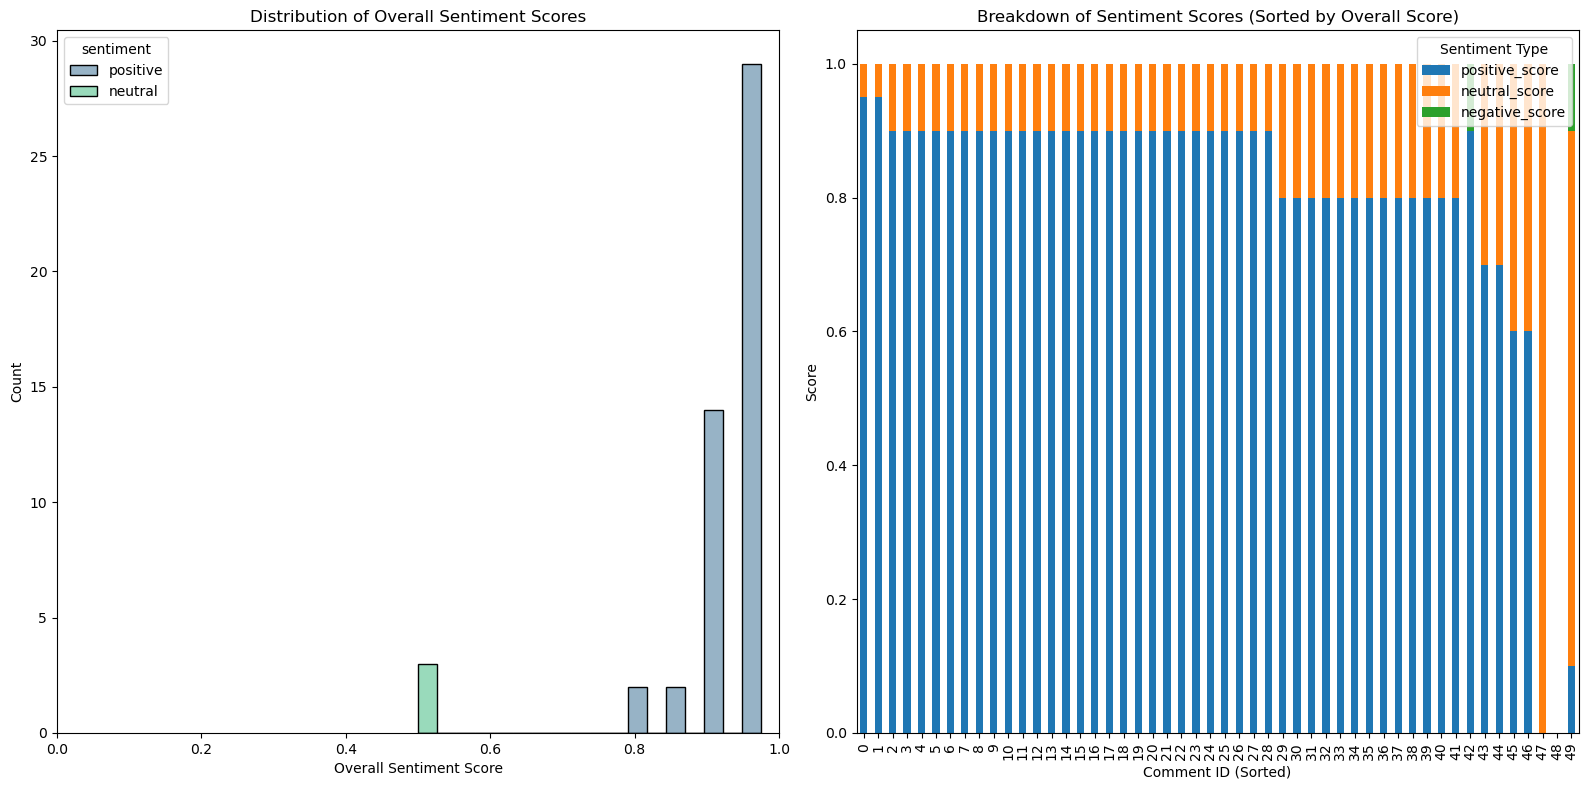

In [32]:
def visualize_sentiment_results(sentiment_results, figsize=(16, 8), max_comments=None):
    """
    Create visualizations for sentiment analysis results.
    
    Parameters:
    sentiment_results (list): List of SentimentAnalysisResult objects
    figsize (tuple): Figure size for the plot (width, height)
    max_comments (int): Maximum number of comments to show in the breakdown graph. If None, show all.
    """

    # Close any existing figures to start fresh
    plt.close('all')

    # Convert the results to a DataFrame
    data = []
    for i, result in enumerate(sentiment_results):
        sentiment = result.overall_sentiment
        data.append({
            'id': i,
            'positive_score': result.positive_score,
            'neutral_score': result.neutral_score,
            'negative_score': result.negative_score,
            'overall_score': sentiment.overall_sentiment_score,
            'sentiment': sentiment.overall_sentiment
        })

    df = pd.DataFrame(data)

    # Sort the DataFrame by overall_score in descending order
    df_sorted = df.sort_values('overall_score', ascending=False).reset_index(drop=True)

    # Limit the number of comments if specified
    if max_comments is not None:
        df_sorted = df_sorted.head(max_comments)

    # Create a new figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # 1. Distribution of Overall Sentiment Scores
    sns.histplot(data=df, x='overall_score', hue='sentiment', kde=False, palette='viridis', ax=ax1)
    ax1.set_title('Distribution of Overall Sentiment Scores')
    ax1.set_xlabel('Overall Sentiment Score')
    ax1.set_ylabel('Count')
    ax1.set_xlim(0.0, 1.0)  # Set x-axis range from 0.0 to 1.0

    # 2. Breakdown of Sentiment Scores (sorted)
    df_sorted[['positive_score', 'neutral_score', 'negative_score']].plot(kind='bar', stacked=True, ax=ax2)
    ax2.set_title('Breakdown of Sentiment Scores (Sorted by Overall Score)')
    ax2.set_xlabel('Comment ID (Sorted)')
    ax2.set_ylabel('Score')
    ax2.legend(title='Sentiment Type')

    # Adjust layout
    plt.tight_layout()

    plt.show()

visualize_sentiment_results(sentiment_results)

# Optional: Print the sorted data for reference
# print(df_sorted[['id', 'overall_score', 'positive_score', 'neutral_score', 'negative_score']])

The visualizations make it pretty clear that most of the comments came across as positive, given that we were asking 'what were the best parts of the course?' Comments that were blank or null show up as empty slots in that righthand graph.

### Comparing to another survey question

Now let's take a look at the answers to "What could we improve about the course?". We might expect that there would be more comments that skew toward negative sentiment. Let's find out.

In [33]:
improve_course_question = 'What could be improved about the course?'
comments_improve = example_survey['improve_course'].tolist()[:25]
sentiment_results_improve = await classify_sentiment(comments=comments_improve, question=improve_course_question)


processing 25 inputs in batches of 25
sleeping for 20 seconds between batches
starting 0 to 25
completed 0 to 25
elapsed time: 14.672798156738281


Let's look at the top couple most positive and most negative results. This time the most negative should be more negative, given that the comments were in response to a question about what could be improved.

In [35]:
comment_result_pairs_improve = list(zip(comments_improve, sentiment_results_improve))
display_top_comments(comment_result_pairs_improve, n=2, sentiment="positive")
display_top_comments(comment_result_pairs_improve, n=2, sentiment="negative")


Top 2 Positive Comments:
Comment: OUTSTANDING
Sentiment: (Overall score: 1.00)
Distribution: +1.00, 0.00, -0.00
--------------------------------------------------------------------------------
Comment: Everything is ideal as it stands.
Sentiment: (Overall score: 0.95)
Distribution: +0.90, 0.10, -0.00
--------------------------------------------------------------------------------

Top 2 Negative Comments:
Comment: The section involving microscopic imagery, where indicators were used
to highlight specific cellular structures, progressed too quickly for
those with limited experience.
Sentiment: (Overall score: 0.20)
Distribution: +0.10, 0.20, -0.70
--------------------------------------------------------------------------------
Comment: The educational videos related to practical applications were
excessively lengthy.
Sentiment: (Overall score: 0.15)
Distribution: +0.00, 0.30, -0.70
--------------------------------------------------------------------------------


### Displaying results

Let's see visually if the comments skewed more negative this time.

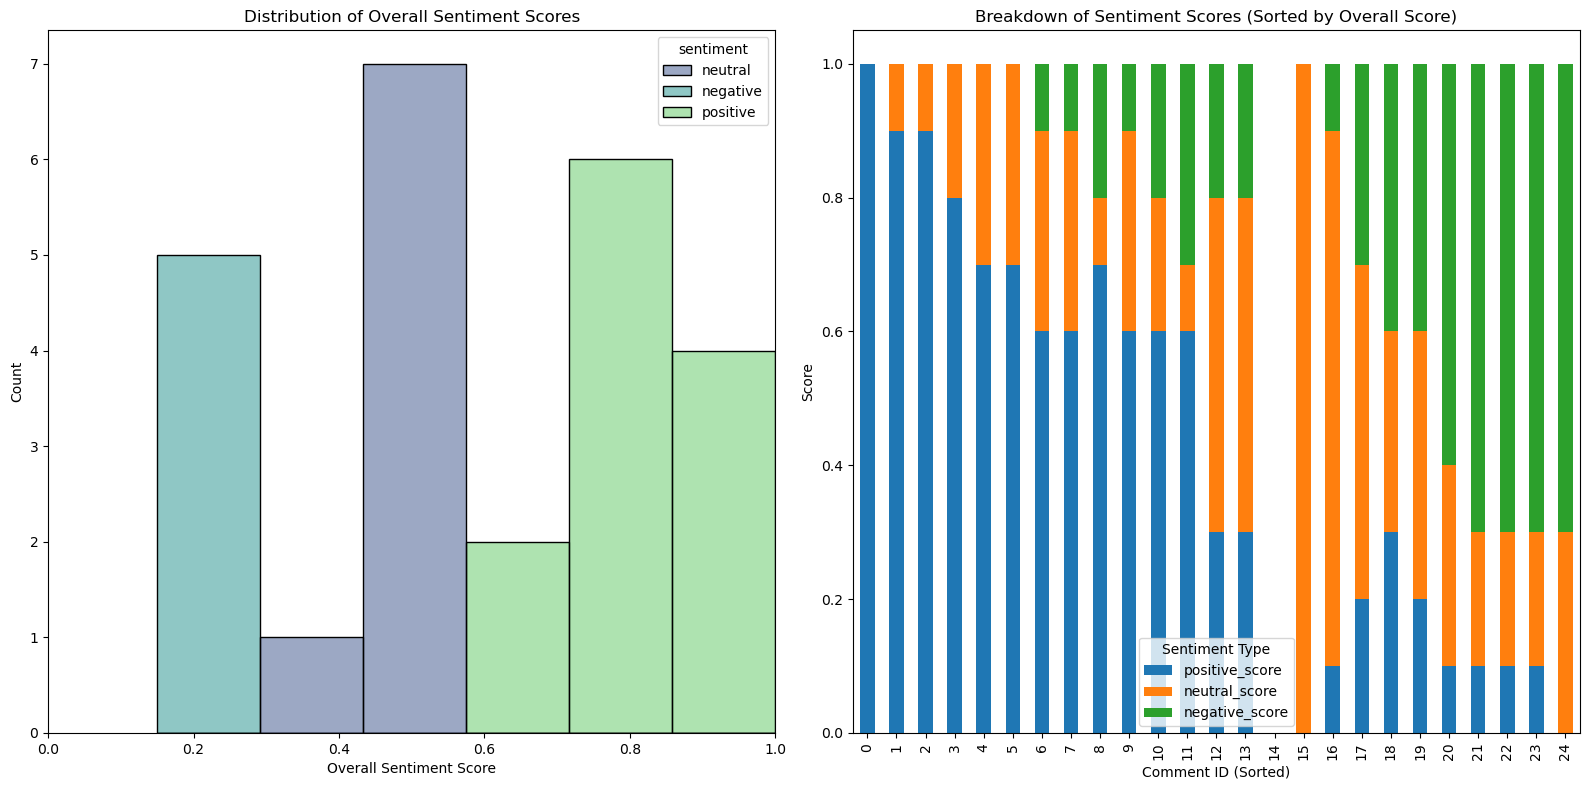

In [36]:
visualize_sentiment_results(sentiment_results_improve)

Sure enough - there are more comments that could be construed as negative, given that's what the "What could be improved about the course?" survey question is prompting for.

## Sentiment analysis for some Coursera comments

These are comments all from one course. There are a lot of duplicate rows in the dataset, for some reason, hence the drop_duplicates.

In [37]:
coursera_review_question = 'What did you think of the course?'
comments_coursera = coursera_survey.iloc[100:125].drop_duplicates()['reviews'].tolist()
sentiment_results_coursera = await classify_sentiment(comments=comments_coursera, question=coursera_review_question)

processing 25 inputs in batches of 25
sleeping for 20 seconds between batches
starting 0 to 25
completed 0 to 25
elapsed time: 21.16711187362671


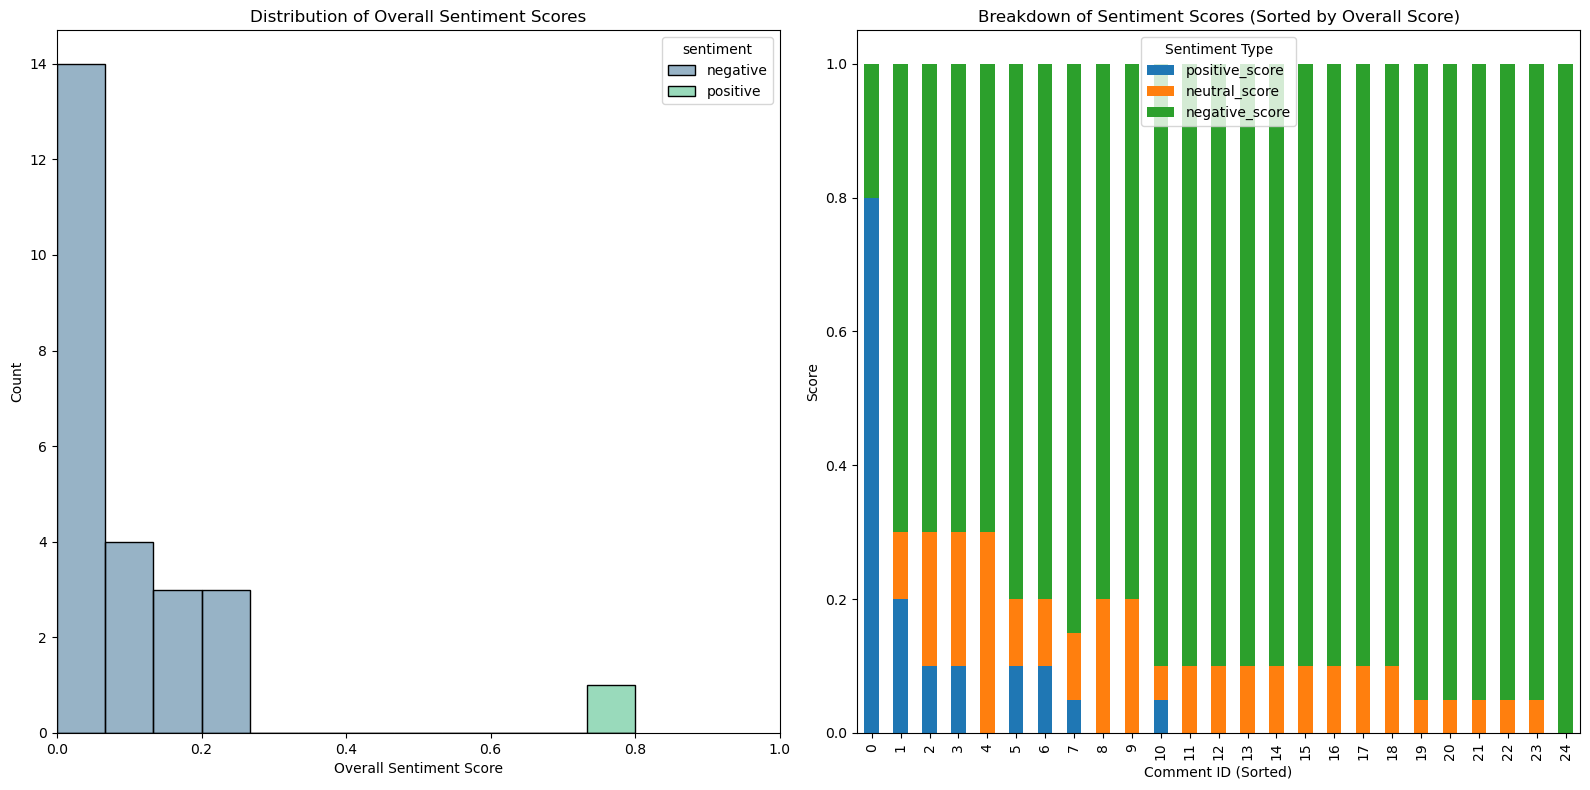

In [38]:
visualize_sentiment_results(sentiment_results_coursera)

^^ Pretty negative sentiment overall. On a practical level, we can see that the model has classified the comments well. Let's see what the comments were about...

In [39]:
comments_coursera

["Not at all legitimate course. The concepts and principles of the course, instructor are not clear. I'm a stock market trader and in one of his quiz the answer of one his question was stop loss at 50% value down. According to this very soon you will find yourself at the footpark. More over he's find out to be staying in the history all the time.",
 'Honestly, this course could have been a lot better but it was very vaguely put together. Definitely not an introductory course.The structure was pretty much all over the place.I later enrolled in for ISBs course on financial markets and it yielded way better results for me.STRUCTURE BAD. CONCEPTS RANDOM. TOPICS NOT ADDRESSED IN DETAIL.',
 'waste of time, I could not understand properly the concepts, as he is not going straight to the point. so I unenrolled after watching few videos',
 'the pace is extremely monotonous and it makes the course really mundane. i want to drop this one and take another one instead, but i just cant!',
 "It was v

Let's try it for a different course.

In [40]:
coursera_review_question = 'What did you think of the course?'
comments_coursera2 = coursera_survey.iloc[:86].drop_duplicates()['reviews'].tolist()
sentiment_results_coursera2 = await classify_sentiment(comments=comments_coursera2, question=coursera_review_question)

processing 33 inputs in batches of 25
sleeping for 20 seconds between batches
starting 0 to 25
completed 0 to 25
elapsed time: 11.807811975479126
sleeping for 8.192188024520874 seconds
starting 25 to 50
completed 25 to 50
elapsed time: 6.343739748001099


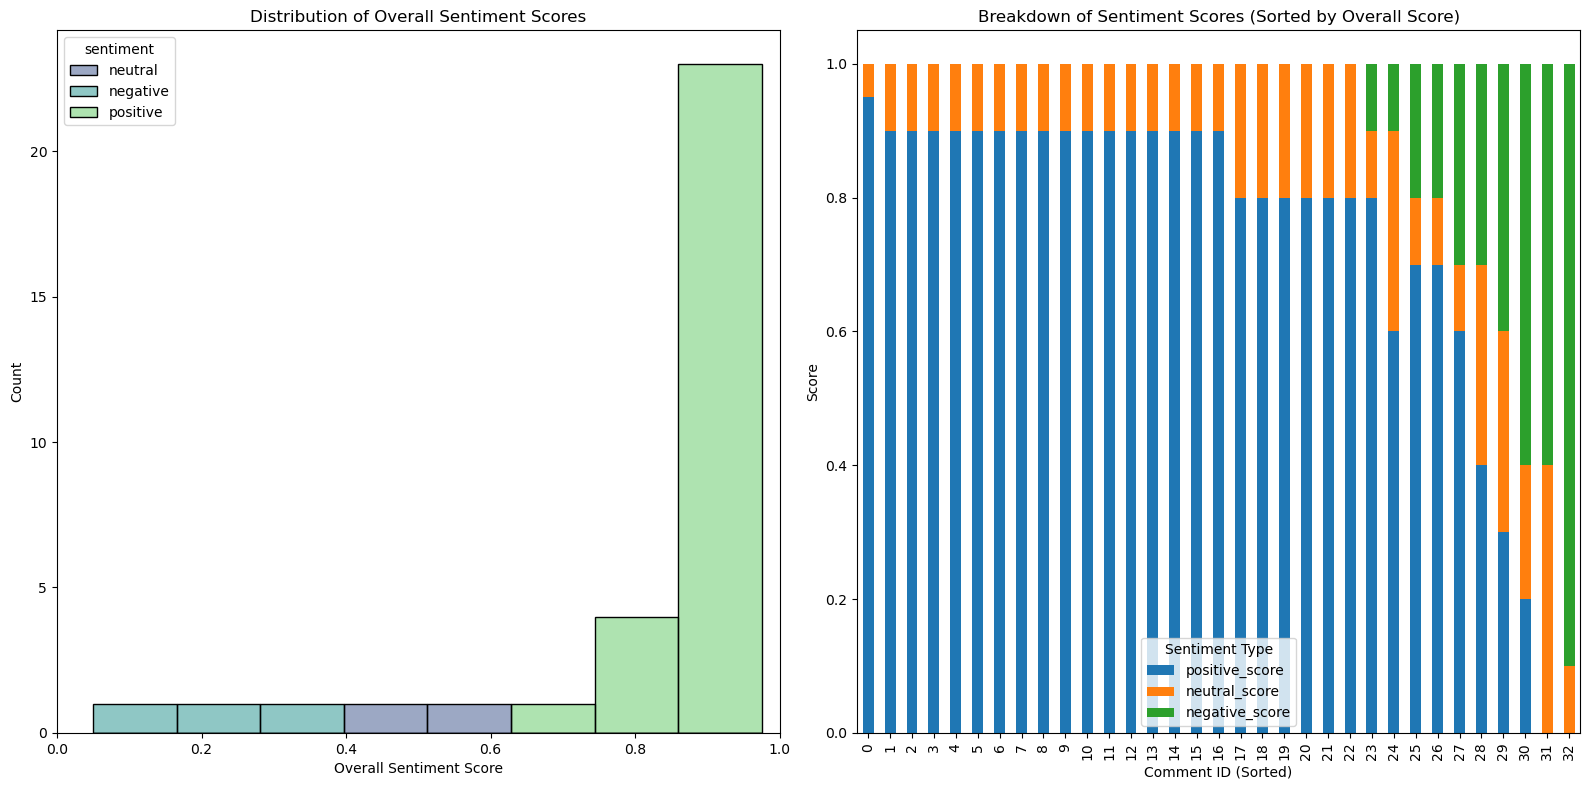

In [41]:
visualize_sentiment_results(sentiment_results_coursera2)

The comments' sentiment for this course seems much more positive. Let's see them...

In [42]:
comments_coursera2

["Pretty dry, but I was able to pass with just two complete watches so I'm happy about that.  As usual there were some questions on the final exam that were NO WHERE in the course, which is annoying but far better than many microsoft tests I have taken.  Never found the suplimental material that the course references... but who cares... i passed!",
 'would be a better experience if the video and screen shots would sho on the side of the text that the instructor is going thru so that user does not have to go all the way to beginning of text to be able to view any slides instructor is showing.',
 'Information was perfect! The program itself was a little annoying. I had to wait 30 to 45 minutes after watching the videos to to take the quiz. Other than that the information was perfect and passed the test with no issues!',
 'A few grammatical mistakes on test made me do a double take but all in all not bad.',
 'Excellent course and the training provided was very detailed and easy to follow.